In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
from glob import glob
import pandas as pd
import numpy as np
from PIL import Image
from numpy.random import seed
seed(7)

In [2]:
base_skin_dir = os.path.join('./dataset')

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, 'trainx/*.bmp'))}

# This dictionary is useful for displaying more human-friendly labels later on

lesion_type_dict = {
    'mel': 'Melanoma',
    'nv': 'Nevus'
}

In [3]:
skin_df = pd.read_csv(os.path.join(base_skin_dir, 'PH2.csv'))


# Creating New Columns for better readability
skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

In [4]:
# Now lets see the sample of tile_df to look on newly made columns
skin_df.head()

,image_id,dx,path,cell_type,cell_type_idx
0,IMD002,nv,./dataset/trainx/IMD002.bmp,Nevus,1
1,IMD003,nv,./dataset/trainx/IMD003.bmp,Nevus,1
2,IMD004,nv,./dataset/trainx/IMD004.bmp,Nevus,1
3,IMD006,nv,./dataset/trainx/IMD006.bmp,Nevus,1
4,IMD008,nv,./dataset/trainx/IMD008.bmp,Nevus,1


In [5]:
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((224,224))))

In [6]:
skin_df.head()

,image_id,dx,path,cell_type,cell_type_idx,image
0,IMD002,nv,./dataset/trainx/IMD002.bmp,Nevus,1,"[[[59, 55, 48], [58, 53, 47], [57, 53, 46], [5..."
1,IMD003,nv,./dataset/trainx/IMD003.bmp,Nevus,1,"[[[44, 40, 36], [45, 40, 39], [46, 40, 40], [4..."
2,IMD004,nv,./dataset/trainx/IMD004.bmp,Nevus,1,"[[[65, 60, 54], [62, 57, 54], [63, 59, 53], [6..."
3,IMD006,nv,./dataset/trainx/IMD006.bmp,Nevus,1,"[[[57, 47, 48], [59, 46, 51], [59, 46, 52], [5..."
4,IMD008,nv,./dataset/trainx/IMD008.bmp,Nevus,1,"[[[62, 56, 56], [64, 54, 57], [62, 54, 55], [6..."


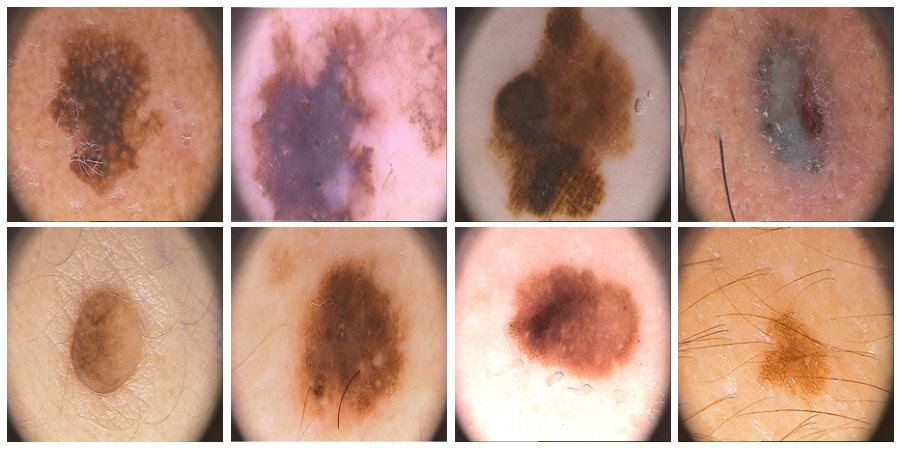

In [7]:
n_samples = 4
fig, m_axs = plt.subplots(2, n_samples, figsize = (4*n_samples, 4*2))

for n_axs, (type_name, type_rows) in zip(m_axs,skin_df.sort_values(['cell_type']).groupby('cell_type')):
    #n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
plt.subplots_adjust(wspace=0.01, hspace=0.02)
fig.savefig('orignal_images.png', dpi=300)

In [8]:
# Checking the image size distribution
skin_df['image'].map(lambda x: x.shape).value_counts()

(224, 224, 3)    200
Name: image, dtype: int64

In [9]:
features=skin_df.drop(columns=['cell_type_idx'],axis=1)
target=skin_df['cell_type_idx']
features.shape

(200, 5)

In [10]:
from sklearn.model_selection import train_test_split
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.3,random_state=42)
x_train_o.shape, x_test_o.shape

((140, 5), (60, 5))

In [11]:
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

#Subtract the mean calculated over per-chanel 3 and devide by standard deviation

# calculate per-channel means and standard deviations
x_train_mean = x_train.mean(axis=(0,1,2), dtype='float64')
x_train_std = x_train.std(axis=(0,1,2), dtype='float64')

x_test_mean = x_test.mean(axis=(0,1,2), dtype='float64')
x_test_std = x_test.std(axis=(0,1,2), dtype='float64')

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

# x_train_mean = np.mean(x_train)
# x_train_std = np.std(x_train)

# x_test_mean = np.mean(x_test)
# x_test_std = np.std(x_test)

# x_train = (x_train - x_train_mean)/x_train_std
# x_test = (x_test - x_test_mean)/x_test_std

In [12]:
import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding

# Perform one-hot encoding on the labels
y_train = to_categorical(y_train_o, num_classes = 2)
y_test = to_categorical(y_test_o, num_classes = 2)

In [13]:
# Reshape image in 3 dimensions (height = 224px, width = 224px , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(224, 224, 3))
x_test = x_test.reshape(x_test.shape[0], *(224, 224, 3))

# Pre-trained model as a feature extractor

In [14]:
import keras, tensorflow
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras import layers 
import numpy as np

# load pre-trained model
base_model = DenseNet121(weights='imagenet')
base_model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [15]:
for layer in base_model.layers:
    layer.trainable = False

x = layers.Flatten()(base_model.get_layer('avg_pool').output)

# load pre-trained model with modification
model = Model(inputs=base_model.input, outputs=x)

In [16]:
train_features = model.predict(x_train)
print(train_features.shape)

test_features = model.predict(x_test)
print(test_features.shape)

(140, 1024)
(60, 1024)


In [17]:
import itertools

# Function to plot confusion matrix for validation image   
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Logistic Regression

CLASSIFICATION REPORT FOR Logistic Regression
Confusion MAtrix:

              precision    recall  f1-score   support

           0       0.89      0.67      0.76        12
           1       0.92      0.98      0.95        48

    accuracy                           0.92        60
   macro avg       0.91      0.82      0.86        60
weighted avg       0.92      0.92      0.91        60

train score: 1.0
test_score 0.9166666666666666


/home/ubuntu/anaconda3/envs/tensorflow/lib/python3.8/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/ubuntu/anaconda3/envs/tensorflow/lib/python3.8/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


,0,1,micro-average
accuracy,0.916667,0.916667,0.916667
precision,0.888889,0.921569,0.916667
recall,0.666667,0.979167,0.916667
specificity,0.979167,0.666667,0.916667
f1,0.761905,0.949495,0.916667


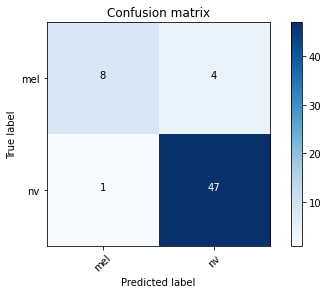

In [18]:
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import GridSearchCV
# Import module for fitting
from sklearn.linear_model import LogisticRegression


# Create instance (i.e. object) of LogisticRegression
classifier = LogisticRegression(random_state=42, C=0.1, penalty ='l2', solver ='newton-cg')

"""## define grid search
parameter_space = {
    'solver' :  ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],  
    'penalty' :  ['l2', 'l1', 'elasticnet'], 
          'C' :  [100, 10, 1.0, 0.1, 0.01]
}
Lr_model = GridSearchCV(classifier, parameter_space, scoring='accuracy', n_jobs=-1, cv=5)
Lr_model.fit(train_features, y_train_o)
# Best paramete set
print("Best: %f using %s" % (Lr_model.best_score_, Lr_model.best_params_))"""

Lr_model = classifier.fit(train_features, y_train_o)

trainscore = Lr_model.score(train_features, y_train_o)
testscore = Lr_model.score(test_features, y_test_o)

test_predictions = Lr_model.predict(test_features)

print("CLASSIFICATION REPORT FOR Logistic Regression")
print("Confusion MAtrix:")
cm = confusion_matrix(y_test_o,test_predictions)
plot_confusion_matrix(cm, classes = lesion_type_dict) 
print()
print(classification_report(y_test_o,test_predictions))
print("train score:",trainscore)
print("test_score",testscore)


# KFold Cross_Validation
#from sklearn.model_selection import cross_val_score
#scores = cross_val_score(Lr_model, train_features, y_train_o, cv=10, scoring='accuracy') #cv is cross validation
#print(scores)
#print()
#print("Average 10 Fold Cross Valodation Score : ", scores.mean())

#Classification Metrix Print
import disarray
import pandas as pd

df = pd.DataFrame(cm)
df.da.export_metrics(metrics_to_include=['accuracy', 'precision', 'recall', 'specificity', 'f1'])

# SVM

CLASSIFICATION REPORT FOR SVM Linear
Confusion MAtrix:
              precision    recall  f1-score   support

           0       0.89      0.67      0.76        12
           1       0.92      0.98      0.95        48

    accuracy                           0.92        60
   macro avg       0.91      0.82      0.86        60
weighted avg       0.92      0.92      0.91        60

train score: 1.0
test_score 0.9166666666666666


,0,1,micro-average
accuracy,0.916667,0.916667,0.916667
precision,0.888889,0.921569,0.916667
recall,0.666667,0.979167,0.916667
specificity,0.979167,0.666667,0.916667
f1,0.761905,0.949495,0.916667


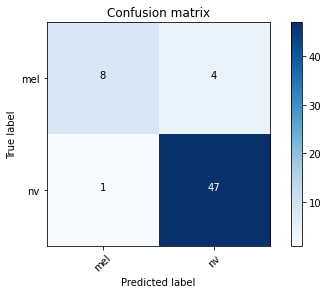

In [19]:
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

classifier = SVC(random_state=42, C=0.01, kernel='linear')

"""## define grid search
parameter_space = {
        'kernel' : ['linear'],  
             'C' : [1000, 100, 50, 10, 1.0, 0.1, 0.01]
}
svmlinear_model = GridSearchCV(classifier, parameter_space, scoring='accuracy', n_jobs=-1, cv=5)
svmlinear_model.fit(train_features, y_train_o)
# Best paramete set
print("Best: %f using %s" % (svmlinear_model.best_score_, svmlinear_model.best_params_))"""


svmlinear_model = classifier.fit(train_features, y_train_o)

trainscore = svmlinear_model.score(train_features, y_train_o)
testscore = svmlinear_model.score(test_features, y_test_o)

test_predictions = svmlinear_model.predict(test_features)

print("CLASSIFICATION REPORT FOR SVM Linear")
print("Confusion MAtrix:")
cm = confusion_matrix(y_test_o,test_predictions)
plot_confusion_matrix(cm, classes = lesion_type_dict) 
#print(cm)
print(classification_report(y_test_o,test_predictions))
print("train score:",trainscore)
print("test_score",testscore)


# KFold Cross_Validation
#from sklearn.model_selection import cross_val_score
#scores = cross_val_score(svm_model, train_features, train_dataset_array_labels, cv=10, scoring='accuracy') #cv is cross validation
#print(scores)
#print()
#print("Average 10 Fold Cross Valodation Score : ", scores.mean())

#Classification Metrix Print
import disarray
import pandas as pd

df = pd.DataFrame(cm)
df.da.export_metrics(metrics_to_include=['accuracy', 'precision', 'recall', 'specificity', 'f1'])


# SVM Redial Kernal

CLASSIFICATION REPORT FOR SVM Redial Kernal
Confusion MAtrix:

              precision    recall  f1-score   support

           0       0.80      0.67      0.73        12
           1       0.92      0.96      0.94        48

    accuracy                           0.90        60
   macro avg       0.86      0.81      0.83        60
weighted avg       0.90      0.90      0.90        60

train score: 1.0
test_score 0.9


,0,1,micro-average
accuracy,0.900000,0.900000,0.9
precision,0.800000,0.920000,0.9
recall,0.666667,0.958333,0.9
specificity,0.958333,0.666667,0.9
f1,0.727273,0.938776,0.9


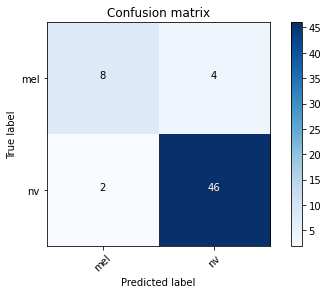

In [20]:
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

#classifier = SVC(random_state=42, C=100.0, cache_size=200, class_weight=None, coef0=0.0, degree=3,
#  gamma=0.10000000000000001, kernel='rbf', probability=False, shrinking=True, tol=0.001)

classifier = SVC(random_state=42, C=4, gamma=0.001, kernel='rbf', tol=2) 
#random_state=42, C=4, gamma=0.001, kernel='rbf', tol=2 - in ISIC2016 - 83.11
#classifier = SVC(random_state=42, C=4, gamma=0.001, kernel='sigmoid', tol=0.001)
#classifier = SVC(random_state=42, C=1, gamma=0.01, kernel='poly',tol=2)
#random_state=42, C=1, gamma=0.01, kernel='rbf', tol=2 -- 91.66%

"""# define grid search
parameter_space = {
        'kernel' : ['rbf','poly'],  
             'C' : [1000,100, 50, 10, 1.0, 0.1, 0.01], 
         'gamma' : [1, 0.1, 0.01, 0.001, 0.0001]
}
svmrbf_model = GridSearchCV(classifier, parameter_space, scoring='accuracy', n_jobs=-1, cv=5)
svmrbf_model.fit(train_features, y_train_o)
# Best paramete set
print("Best: %f using %s" % (svmrbf_model.best_score_, svmrbf_model.best_params_))"""


svmrbf_model = classifier.fit(train_features, y_train_o)

trainscore = svmrbf_model.score(train_features, y_train_o)
testscore = svmrbf_model.score(test_features, y_test_o)

test_predictions = svmrbf_model.predict(test_features)

print("CLASSIFICATION REPORT FOR SVM Redial Kernal")
print("Confusion MAtrix:")
cm = confusion_matrix(y_test_o,test_predictions)
plot_confusion_matrix(cm, classes = lesion_type_dict) 
print()
print(classification_report(y_test_o,test_predictions))
print("train score:",trainscore)
print("test_score",testscore)

# KFold Cross_Validation
#from sklearn.model_selection import cross_val_score
#scores = cross_val_score(svm_model, train_features, train_dataset_array_labels, cv=10, scoring='accuracy') #cv is cross validation
#print(scores)
#print("Average 10 Fold Cross Valodation Score : ", scores.mean())


#Classification Metrix Print
import disarray
import pandas as pd

df = pd.DataFrame(cm)
df.da.export_metrics(metrics_to_include=['accuracy', 'precision', 'recall', 'specificity', 'f1'])


# Naive Bayes

CLASSIFICATION REPORT FOR Naive Bayes
Confusion MAtrix:

              precision    recall  f1-score   support

           0       0.75      0.75      0.75        12
           1       0.94      0.94      0.94        48

    accuracy                           0.90        60
   macro avg       0.84      0.84      0.84        60
weighted avg       0.90      0.90      0.90        60

train score: 0.9571428571428572
test_score 0.9


,0,1,micro-average
accuracy,0.9000,0.9000,0.9
precision,0.7500,0.9375,0.9
recall,0.7500,0.9375,0.9
specificity,0.9375,0.7500,0.9
f1,0.7500,0.9375,0.9


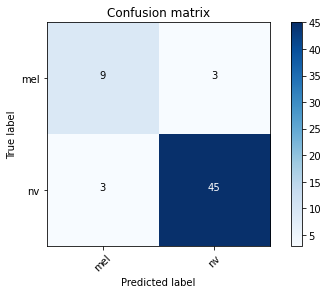

In [21]:
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB

#Create a Gaussian Classifier
classifier = GaussianNB(var_smoothing=0.001)

# Train the model using the training sets
nb_model = classifier.fit(train_features,  y_train_o)

trainscore = nb_model.score(train_features,  y_train_o)
testscore = nb_model.score(test_features,  y_test_o)

test_predictions = nb_model.predict(test_features)

print("CLASSIFICATION REPORT FOR Naive Bayes")
print("Confusion MAtrix:")
cm = confusion_matrix(y_test_o,test_predictions)
plot_confusion_matrix(cm, classes = lesion_type_dict) 
print()
print(classification_report(y_test_o,test_predictions))
print("train score:",trainscore)
print("test_score",testscore)


# KFold Cross_Validation
#from sklearn.model_selection import cross_val_score
#scores = cross_val_score(nb_model, train_features, train_dataset_array_labels, cv=10, scoring='accuracy') #cv is cross validation
#print(scores)
#print("Average 10 Fold Cross Valodation Score : ", scores.mean())

#Classification Metrix Print
import disarray
import pandas as pd

df = pd.DataFrame(cm)
df.da.export_metrics(metrics_to_include=['accuracy', 'precision', 'recall', 'specificity', 'f1'])

# Ada Boost

CLASSIFICATION REPORT FOR Ada Boost
Confusion MAtrix:

              precision    recall  f1-score   support

           0       0.91      0.83      0.87        12
           1       0.96      0.98      0.97        48

    accuracy                           0.95        60
   macro avg       0.93      0.91      0.92        60
weighted avg       0.95      0.95      0.95        60

train score: 1.0
test_score 0.95


,0,1,micro-average
accuracy,0.950000,0.950000,0.95
precision,0.909091,0.959184,0.95
recall,0.833333,0.979167,0.95
specificity,0.979167,0.833333,0.95
f1,0.869565,0.969072,0.95


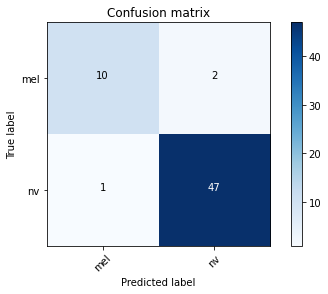

In [22]:
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier

# Create adaboost classifer object
classifier = AdaBoostClassifier(random_state=42, learning_rate=1.7, n_estimators=200)


"""## define grid search
parameter_space = {
        'n_estimators'  : [50, 100, 200, 250],
        'learning_rate' : [0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 1, 1.5, 2]
}
Ab_model = GridSearchCV(classifier, parameter_space, scoring='accuracy', n_jobs=-1, cv=5)
Ab_model.fit(train_features, y_train_o)
# Best paramete set
print("Best: %f using %s" % (Ab_model.best_score_, Ab_model.best_params_))"""



# Train Adaboost Classifer
Ab_model = classifier.fit(train_features, y_train_o)

#Predict the response for test dataset
trainscore = Ab_model.score(train_features, y_train_o)
testscore = Ab_model.score(test_features, y_test_o)

test_predictions = Ab_model.predict(test_features)

print("CLASSIFICATION REPORT FOR Ada Boost")
print("Confusion MAtrix:")
cm = confusion_matrix(y_test_o,test_predictions)
plot_confusion_matrix(cm, classes = lesion_type_dict)
print()
print(classification_report(y_test_o,test_predictions))
print("train score:",trainscore)
print("test_score",testscore)


# KFold Cross_Validation
#from sklearn.model_selection import cross_val_score
#scores = cross_val_score(Ab_model, train_features, train_dataset_array_labels, cv=10, scoring='accuracy') #cv is cross validation
#print(scores)
#print("Average 10 Fold Cross Valodation Score : ", scores.mean())

#Classification Metrix Print
import disarray
import pandas as pd

df = pd.DataFrame(cm)
df.da.export_metrics(metrics_to_include=['accuracy', 'precision', 'recall', 'specificity', 'f1'])


# Random Forest

CLASSIFICATION REPORT FOR Random Forest
Confusion MAtrix:

              precision    recall  f1-score   support

           0       0.89      0.67      0.76        12
           1       0.92      0.98      0.95        48

    accuracy                           0.92        60
   macro avg       0.91      0.82      0.86        60
weighted avg       0.92      0.92      0.91        60

train score: 1.0
test_score 0.9166666666666666


,0,1,micro-average
accuracy,0.916667,0.916667,0.916667
precision,0.888889,0.921569,0.916667
recall,0.666667,0.979167,0.916667
specificity,0.979167,0.666667,0.916667
f1,0.761905,0.949495,0.916667


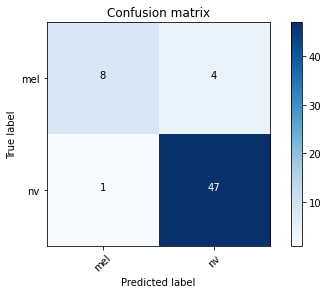

In [23]:
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import GridSearchCV
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(random_state=42, max_features='sqrt', n_estimators=50)

"""## define grid search
parameter_space = {
         'max_features': ['sqrt', 'log2'],
         'n_estimators': [100, 150, 200, 300]
}
Rf_model = GridSearchCV(classifier, parameter_space, scoring='accuracy', n_jobs=-1, cv=5)
Rf_model.fit(train_features, y_train_o)
# Best paramete set
print("Best: %f using %s" % (Rf_model.best_score_, Rf_model.best_params_))"""


#Train the model using the training sets 
Rf_model = classifier.fit(train_features, y_train_o)

#Predict the response for test dataset
trainscore = Rf_model.score(train_features, y_train_o)
testscore = Rf_model.score(test_features, y_test_o)

test_predictions = Rf_model.predict(test_features)

print("CLASSIFICATION REPORT FOR Random Forest")
print("Confusion MAtrix:")
cm = confusion_matrix(y_test_o,test_predictions)
plot_confusion_matrix(cm, classes = lesion_type_dict)
print()
print(classification_report(y_test_o,test_predictions))
print("train score:",trainscore)
print("test_score",testscore)


# KFold Cross_Validation
#from sklearn.model_selection import cross_val_score
#scores = cross_val_score(Rf_model, train_features, train_dataset_array_labels, cv=10, scoring='accuracy') #cv is cross validation
#print(scores)
#print("Average 10 Fold Cross Valodation Score : ", scores.mean())


#Classification Metrix Print
import disarray
import pandas as pd

df = pd.DataFrame(cm)
df.da.export_metrics(metrics_to_include=['accuracy', 'precision', 'recall', 'specificity', 'f1'])

# linear discriminant analysis

CLASSIFICATION REPORT FOR Linear Discriminant Analysis
Confusion MAtrix:

              precision    recall  f1-score   support

           0       0.73      0.67      0.70        12
           1       0.92      0.94      0.93        48

    accuracy                           0.88        60
   macro avg       0.82      0.80      0.81        60
weighted avg       0.88      0.88      0.88        60

train score: 0.9785714285714285
test_score 0.8833333333333333


,0,1,micro-average
accuracy,0.883333,0.883333,0.883333
precision,0.727273,0.918367,0.883333
recall,0.666667,0.937500,0.883333
specificity,0.937500,0.666667,0.883333
f1,0.695652,0.927835,0.883333


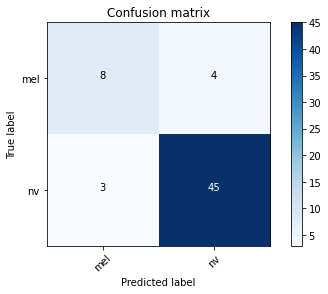

In [24]:
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

#classifier = LinearDiscriminantAnalysis(solver='lsqr', shrinkage=0.3)
classifier = LinearDiscriminantAnalysis()

"""## define grid search
parameter_space = {
        'solver' : ['svd', 'lsqr', 'eigen']
}
Lda_model = GridSearchCV(classifier, parameter_space, scoring='accuracy', n_jobs=-1, cv=5)
Lda_model.fit(train_features, y_train_o)
# Best paramete set
print("Best: %f using %s" % (Lda_model.best_score_, Lda_model.best_params_))"""


#Train the model using the training sets 
Lda_model = classifier.fit(train_features, y_train_o)

#Predict the response for test dataset
trainscore = Lda_model.score(train_features, y_train_o)
testscore = Lda_model.score(test_features, y_test_o)

test_predictions = Lda_model.predict(test_features)

print("CLASSIFICATION REPORT FOR Linear Discriminant Analysis")
print("Confusion MAtrix:")
cm = confusion_matrix(y_test_o,test_predictions)
plot_confusion_matrix(cm, classes = lesion_type_dict)
print()
print(classification_report(y_test_o,test_predictions))
print("train score:",trainscore)
print("test_score",testscore)


# KFold Cross_Validation
#from sklearn.model_selection import cross_val_score
#scores = cross_val_score(Lda_model, train_features, train_dataset_array_labels, cv=10, scoring='accuracy') #cv is cross validation
#print(scores)
#print("Average 10 Fold Cross Valodation Score : ", scores.mean())


#Classification Metrix Print
import disarray
import pandas as pd

df = pd.DataFrame(cm)
df.da.export_metrics(metrics_to_include=['accuracy', 'precision', 'recall', 'specificity', 'f1'])

# K Nearest Neighbor

CLASSIFICATION REPORT FOR K Nearest Neighbor
Confusion MAtrix:

              precision    recall  f1-score   support

           0       0.73      0.67      0.70        12
           1       0.92      0.94      0.93        48

    accuracy                           0.88        60
   macro avg       0.82      0.80      0.81        60
weighted avg       0.88      0.88      0.88        60

train score: 0.9428571428571428
test_score 0.8833333333333333


,0,1,micro-average
accuracy,0.883333,0.883333,0.883333
precision,0.727273,0.918367,0.883333
recall,0.666667,0.937500,0.883333
specificity,0.937500,0.666667,0.883333
f1,0.695652,0.927835,0.883333


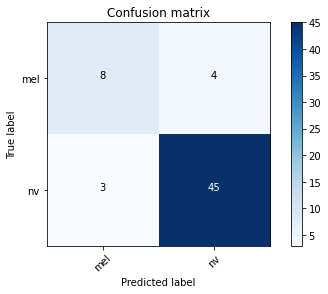

In [25]:
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

classifier = KNeighborsClassifier(n_neighbors=3,p=1)
#When p = 1, this is equivalent to using manhattan_distance (l1), and euclidean_distance (l2) 
#for p = 2. For arbitrary p, minkowski_distance (l_p) is used.

"""## define grid search
parameter_space = {
        'n_neighbors' : [1,3,5,7,9],
          'weights'   : ['uniform', 'distance'], 
          'algorithm' : ['auto', 'ball_tree','kd_tree','brute']
}
Knn_model = GridSearchCV(classifier, parameter_space, scoring='accuracy', n_jobs=-1, cv=5)
Knn_model.fit(train_features, y_train_o)
# Best paramete set
print("Best: %f using %s" % (Knn_model.best_score_, Knn_model.best_params_))"""


#Train the model using the training sets 
Knn_model = classifier.fit(train_features, y_train_o)

#Predict the response for test dataset
trainscore = Knn_model.score(train_features, y_train_o)
testscore = Knn_model.score(test_features, y_test_o)

test_predictions = Knn_model.predict(test_features)

print("CLASSIFICATION REPORT FOR K Nearest Neighbor")
print("Confusion MAtrix:")
cm = confusion_matrix(y_test_o,test_predictions)
plot_confusion_matrix(cm, classes = lesion_type_dict)
print()
print(classification_report(y_test_o,test_predictions))
print("train score:",trainscore)
print("test_score",testscore)


# KFold Cross_Validation
#from sklearn.model_selection import cross_val_score
#scores = cross_val_score(Lda_model, train_features, train_dataset_array_labels, cv=10, scoring='accuracy') #cv is cross validation
#print(scores)
#print("Average 10 Fold Cross Valodation Score : ", scores.mean())


#Classification Metrix Print
import disarray
import pandas as pd

df = pd.DataFrame(cm)
df.da.export_metrics(metrics_to_include=['accuracy', 'precision', 'recall', 'specificity', 'f1'])

# Neural Network

CLASSIFICATION REPORT FOR Neural Network
Confusion MAtrix:

              precision    recall  f1-score   support

           0       0.91      0.83      0.87        12
           1       0.96      0.98      0.97        48

    accuracy                           0.95        60
   macro avg       0.93      0.91      0.92        60
weighted avg       0.95      0.95      0.95        60

train score: 1.0
test_score 0.95


,0,1,micro-average
accuracy,0.950000,0.950000,0.95
precision,0.909091,0.959184,0.95
recall,0.833333,0.979167,0.95
specificity,0.979167,0.833333,0.95
f1,0.869565,0.969072,0.95


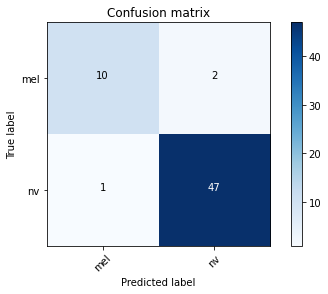

In [26]:
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier

classifier = MLPClassifier(random_state=42, activation='relu', hidden_layer_sizes= (50,200,200,100), 
                           learning_rate='constant', solver='adam')

"""## define grid search
parameter_space = {
        'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
         'activation': ['tanh', 'relu', 'logistic'],
            'solver': ['lbfgs', 'sgd', 'adam'],
             'alpha': [0.0001, 0.05],
          'learning_rate': ['constant','invscaling','adaptive']
}
Mlp_model = GridSearchCV(classifier, parameter_space, scoring='accuracy', n_jobs=-1, cv=5)
Mlp_model.fit(train_features, y_train_o)
# Best paramete set
print("Best: %f using %s" % (Mlp_model.best_score_, Mlp_model.best_params_))"""


#Train the model using the training sets 
Mlp_model = classifier.fit(train_features, y_train_o)

#Predict the response for test dataset
trainscore = Mlp_model.score(train_features, y_train_o)
testscore = Mlp_model.score(test_features, y_test_o)

test_predictions = Mlp_model.predict(test_features)

print("CLASSIFICATION REPORT FOR Neural Network")
print("Confusion MAtrix:")
cm = confusion_matrix(y_test_o,test_predictions)
plot_confusion_matrix(cm, classes = lesion_type_dict)
print()
print(classification_report(y_test_o,test_predictions))
print("train score:",trainscore)
print("test_score",testscore)


# KFold Cross_Validation
#from sklearn.model_selection import cross_val_score
#scores = cross_val_score(Lda_model, train_features, train_dataset_array_labels, cv=10, scoring='accuracy') #cv is cross validation
#print(scores)
#print("Average 10 Fold Cross Valodation Score : ", scores.mean())


#Classification Metrix Print
import disarray
import pandas as pd

df = pd.DataFrame(cm)
df.da.export_metrics(metrics_to_include=['accuracy', 'precision', 'recall', 'specificity', 'f1'])

# Decision Tree

CLASSIFICATION REPORT FOR Decision Tree
Confusion MAtrix:

              precision    recall  f1-score   support

           0       0.86      0.50      0.63        12
           1       0.89      0.98      0.93        48

    accuracy                           0.88        60
   macro avg       0.87      0.74      0.78        60
weighted avg       0.88      0.88      0.87        60

train score: 0.8928571428571429
test_score 0.8833333333333333


,0,1,micro-average
accuracy,0.883333,0.883333,0.883333
precision,0.857143,0.886792,0.883333
recall,0.500000,0.979167,0.883333
specificity,0.979167,0.500000,0.883333
f1,0.631579,0.930693,0.883333


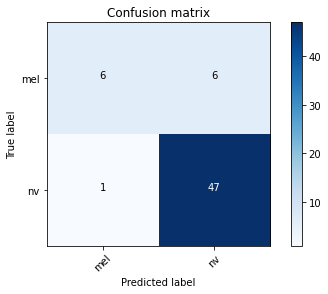

In [27]:
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

classifier = DecisionTreeClassifier(random_state=42, criterion='entropy', max_depth=2, max_features='log2')

"""## define grid search
parameter_space = {
         'criterion' : ['gini', 'entropy'],
         'max_depth' : [2,4,6,8,10,12],
        'max_features': ['auto', 'sqrt', 'log2'],
        'min_samples_split': [2,3,4,5,6,7,8,9,10,11,12,13,14,15], 
        'min_samples_leaf':[1,2,3,4,5,6,7,8,9,10,11],
}
Dt_model = GridSearchCV(classifier, parameter_space, scoring='accuracy', n_jobs=-1, cv=5)
Dt_model.fit(train_features, y_train_o)
# Best paramete set
print("Best: %f using %s" % (Dt_model.best_score_, Dt_model.best_params_))"""


#Train the model using the training sets 
Dt_model = classifier.fit(train_features, y_train_o)

#Predict the response for test dataset
trainscore = Dt_model.score(train_features, y_train_o)
testscore = Dt_model.score(test_features, y_test_o)

test_predictions = Dt_model.predict(test_features)

print("CLASSIFICATION REPORT FOR Decision Tree")
print("Confusion MAtrix:")
cm = confusion_matrix(y_test_o,test_predictions)
plot_confusion_matrix(cm, classes = lesion_type_dict)
print()
print(classification_report(y_test_o,test_predictions))
print("train score:",trainscore)
print("test_score",testscore)


# KFold Cross_Validation
#from sklearn.model_selection import cross_val_score
#scores = cross_val_score(Lda_model, train_features, train_dataset_array_labels, cv=10, scoring='accuracy') #cv is cross validation
#print(scores)
#print("Average 10 Fold Cross Valodation Score : ", scores.mean())


#Classification Metrix Print
import disarray
import pandas as pd

df = pd.DataFrame(cm)
df.da.export_metrics(metrics_to_include=['accuracy', 'precision', 'recall', 'specificity', 'f1'])